Trying to better understand these health parameters...

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import linalg
import math
from src.moduls import * #showing_standard_info, healthy_vs_diseased_info, healthy_vs_diseased
from src.io_utils import *
from src.viz import *
import statsmodels.api as sm


np.random.seed(42)

df = clean_data(read_data("dataset/health_study_dataset.csv"))

df.sample(10)






,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
696,697,54,M,179.5,103.7,151.2,5.28,Yes,0
667,668,72,M,172.1,103.4,164.3,5.93,No,0
63,64,32,F,167.0,58.9,129.5,2.81,No,0
533,534,31,M,172.1,55.7,124.8,4.73,No,1
66,67,48,M,185.2,83.0,144.6,5.46,No,1
621,622,57,F,159.0,55.5,162.5,3.72,No,0
346,347,28,M,180.8,88.6,148.1,4.97,No,1
490,491,49,F,171.2,91.1,131.8,6.10,No,0
760,761,41,F,166.2,66.9,142.5,4.48,Yes,0
456,457,48,F,173.5,61.0,140.9,4.66,No,0


Let's see the information about the maximum, minimum, mean and median of: age, weight, height, systolic_bp, cholesterol.

In [2]:
showing_standard_info(df)

,age,weight,height,systolic_bp,cholesterol
Max,90.00000,114.400,200.40000,185.900000,7.88000
Min,18.00000,33.700,144.40000,106.800000,2.50000
Medel,49.42625,73.413,171.84925,149.178625,4.92915
Median,50.00000,73.200,171.35000,149.400000,4.97000


It's time to see if we can see any difference between the weight of the different sexes

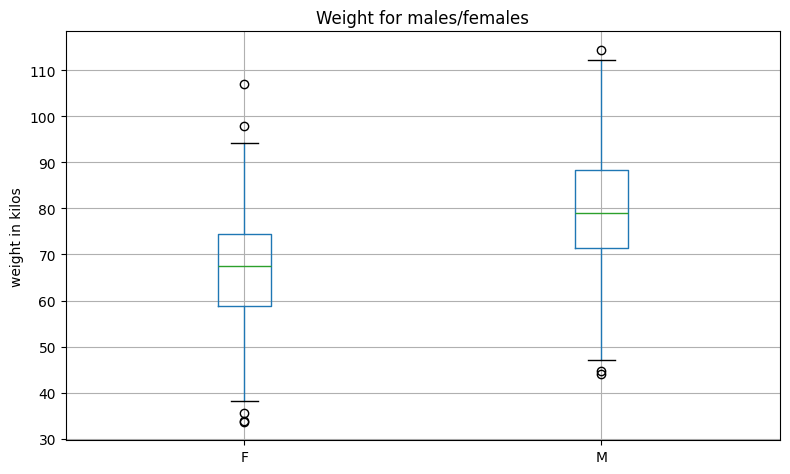

In [3]:
plot_gender_weight_difference(df)






So in general men tends to weight more than women. But let's compare some more and see if we can find a pattern between sex, smokers and blood pressure of sick and healthy people.

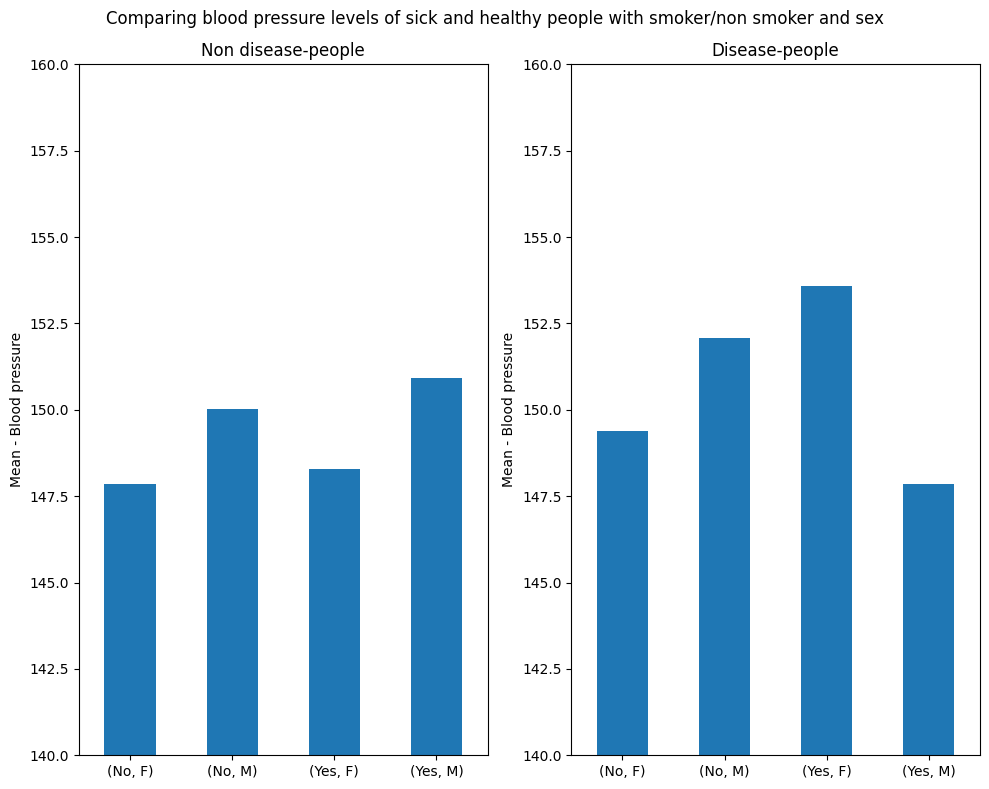

In [4]:
tuple_of_healthy_vs_diseased = healthy_vs_diseased_info(df)

plot_disease_vs_healthy(tuple_of_healthy_vs_diseased[1], tuple_of_healthy_vs_diseased[0])

Comparing age with cholesterol

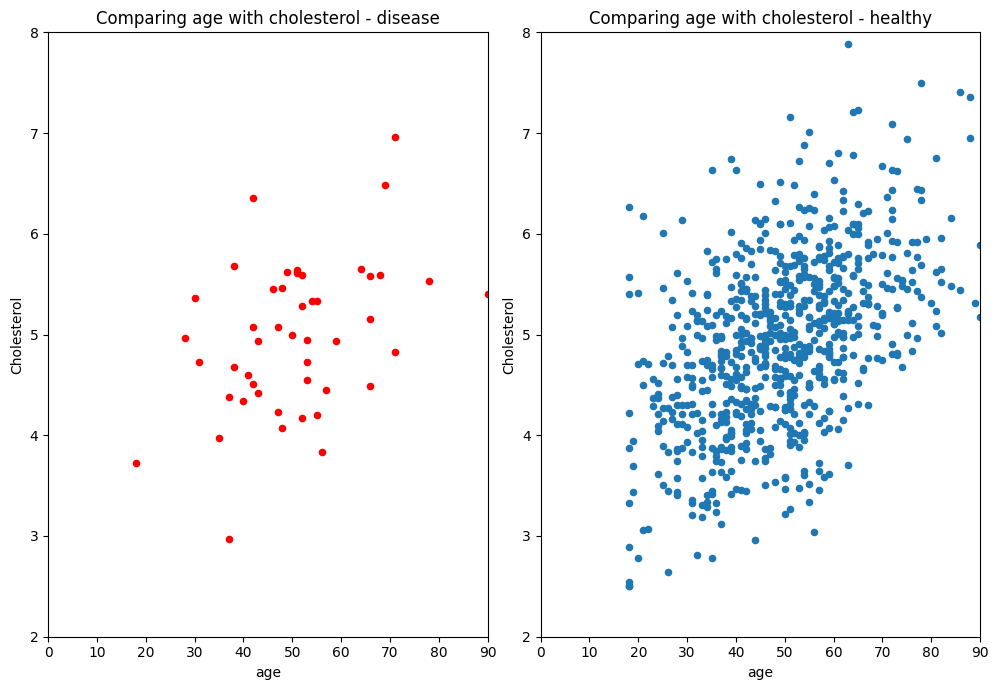

In [5]:
tuple_of_healthy_vs_diseased_mask = healthy_vs_diseased(df)
plot_comparing_age_with_cholesterol(tuple_of_healthy_vs_diseased_mask[0], tuple_of_healthy_vs_diseased_mask[1])

Too few datapoints to draw any insights. Let's calculate the frequency of our sample having the sickness and compare it to a random 

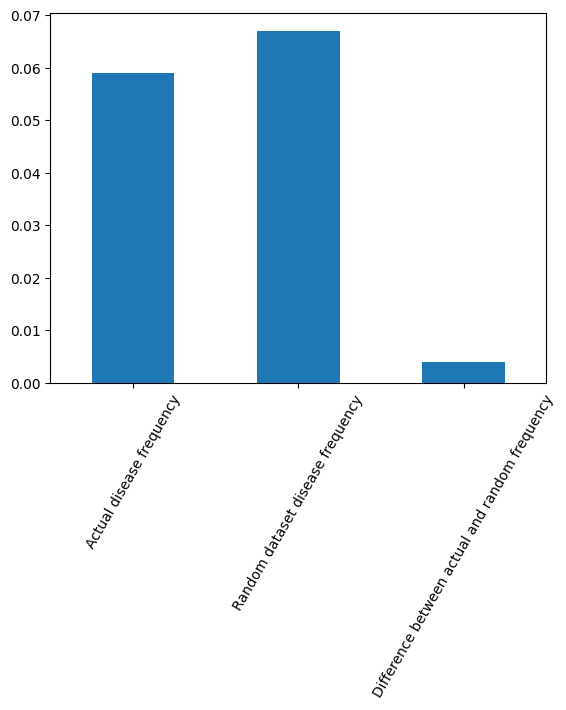

In [21]:
dictionary_of_disease_frequency_and_frequency_from_random_dataset = {}
dictionary_of_disease_frequency_and_frequency_from_random_dataset["Actual disease frequency"] = frequency_of_diseased(df)
dictionary_of_disease_frequency_and_frequency_from_random_dataset["Random dataset disease frequency"] = round(np.mean(creating_a_random_data_set_with_disease_frequency(df)), 3)
dictionary_of_disease_frequency_and_frequency_from_random_dataset["Difference between actual and random frequency"] = round(abs(frequency_of_diseased(df) - np.mean(creating_a_random_data_set_with_disease_frequency(df))), 3)

df_frequency = pd.Series(dictionary_of_disease_frequency_and_frequency_from_random_dataset)

df_frequency.plot.bar()
plt.tick_params(axis="x", rotation=60)
plt.tight_layout
plt.show()





Hmm now that we can compare the frequency of the diseased from the frequency of the healthy, let us do a confidence interval of systolic_bp

In [7]:
df_systolic_bp = df["systolic_bp"]

lo, hi, mean_x, s, n = ci_mean_norma(df_systolic_bp)

print(lo, hi, mean_x, s, n)
print(np.mean(df_systolic_bp))



148.29209036025347 150.06515963974655 149.178625 12.793360316766597 800
149.178625


The 95% confidence interval is 149.178625 +- 0.886 535. 

Let's see what happens when we do it with bootstrap

148.30199375 150.071384375 149.178625
None
(148.305615625, 150.066875, 149.178625)
Skillnaderna mellan lägsta, högsta och medelvärdet av bootstrap vs normalapproximation 9.348525347263603e-05 0.0051565147465453265 0.0


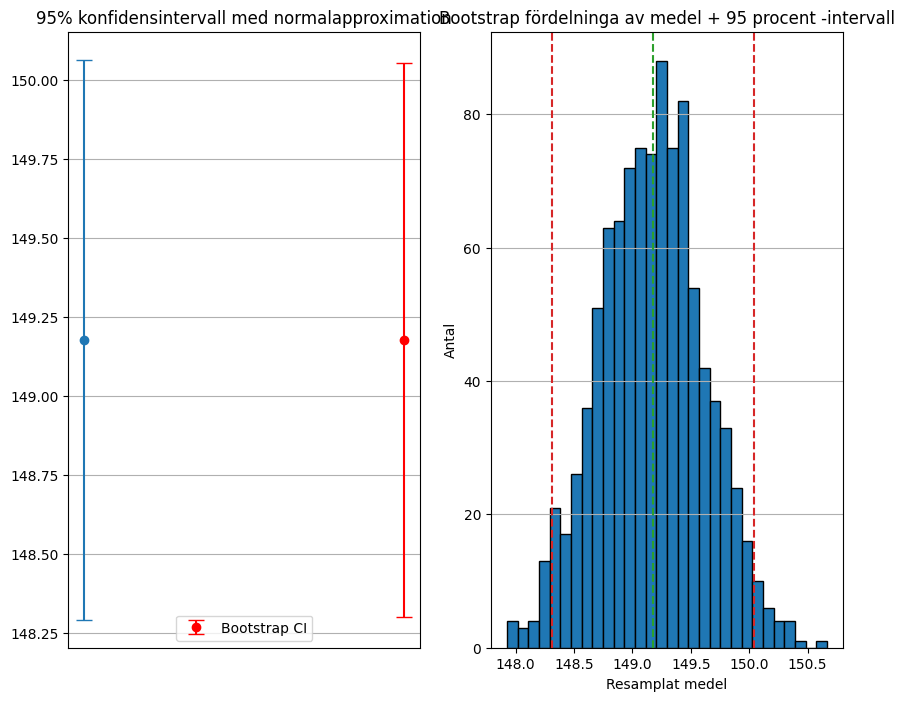

In [8]:
blo, bhi, bmean = ci_mean_bootstrap(df_systolic_bp)

print(blo, bhi, bmean)

print(ci_mean_and_ci_bootstrap(df_systolic_bp))
print(ci_mean_bootstrap(df_systolic_bp))

lo, hi, mean_x, s, n = ci_mean_norma(df_systolic_bp)
blo, bhi, bmean = ci_mean_bootstrap(df_systolic_bp)

print("Skillnaderna mellan lägsta, högsta och medelvärdet av bootstrap vs normalapproximation", abs(lo - blo), abs(hi - bhi), abs(mean_x - bmean))



But could it perhaps be that the people who have the disease have higher blood pressure than our total sample? Let's try this hypothesis!

In [9]:
df["systolic_bp"].mean()

disease, healthy = healthy_vs_diseased(df)

disease["systolic_bp"]

stats.ttest_1samp(a=disease["systolic_bp"], 
                  popmean=df["systolic_bp"].mean())
# stats.t.ppf(q=0.025,
#             df=len(df) - 1)

TtestResult(statistic=np.float64(0.827253141004154), pvalue=np.float64(0.4123645746921004), df=np.int64(46))

Well, we couldn't tell a damn thing. We just tried the hypothesis that diseased have a different mean than our sample. But let's compare the disease to the non disease group using two sample t-test.

In [10]:
disease, healthy = healthy_vs_diseased(df)

stats.ttest_ind(a=disease["systolic_bp"],
                b=healthy["systolic_bp"],
                equal_var=False)

TtestResult(statistic=np.float64(0.8541835931340537), pvalue=np.float64(0.39695573395339223), df=np.float64(51.54602842475532))

Even now we have some problems: our p-value is 0.400 which mean that we cannot reject our null hypothesis: that the disease-group have higher blood pressure. Let's instead check if smokers have higher blood pressure than non smokers.

In [11]:
smokers, non_smokers = looking_for_them_smokers(df)

stats.ttest_ind(a=smokers["systolic_bp"],
                b=non_smokers["systolic_bp"],
                equal_var=False)



TtestResult(statistic=np.float64(0.4503433193393224), pvalue=np.float64(0.6527338743398998), df=np.float64(360.15254973870043))

In [26]:
import numpy as np
from scipy import stats

# --- PARAMETRAR BASERADE PÅ DINA DATA ---
n_sick = 47           # Stickprovsstorlek för Sjuka (Grupp 1)
n_healthy = 753       # Stickprovsstorlek för Friska (Grupp 2)
std_sick = 13.17      # Standardavvikelse Sjuka (Grupp 1)
std_healthy = 12.77   # Standardavvikelse Friska (Grupp 2)

# Antaganden för simuleringen (Verklighet)
mean_healthy = 120    # Baslinjemedelvärde (Spelar ingen roll vad det är, bara skillnaden)
diff_to_find = 2      # Den antagna verkliga skillnaden (2 mmHg)
mean_sick = mean_healthy + diff_to_find # 122 mmHg

alpha = 0.05          # Signifikansnivå
n_simulations = 1000  # Antal gånger testet körs

# --- GENOMFÖR SIMULERINGEN ---
significant_results = 0

for _ in range(n_simulations):
    # Generera syntetiska data (normalfördelade) med kända medelvärden och standardavvikelser
    sick_data = np.random.normal(loc=mean_sick, scale=std_sick, size=n_sick)
    healthy_data = np.random.normal(loc=mean_healthy, scale=std_healthy, size=n_healthy)

    # Kör t-testet för oberoende stickprov (equal_var=False)
    # Observera: Statsmodels' t-test är mer avancerat, men scipy's är standard för simuleringar
    t_stat, p_value = stats.ttest_ind(
        a=sick_data, 
        b=healthy_data, 
        equal_var=False
    )

    # Räkna hur många gånger den verkliga skillnaden hittades (p-värde < alpha)
    if p_value < alpha:
        significant_results += 1

# Beräkna testets styrka (Power)
power = significant_results / n_simulations

print(f"--- Resultat av Simulering ---")
print(f"Antagen verklig skillnad (Effektstorlek): {diff_to_find} mmHg")
print(f"Stickprovsstorlekar: Sjuka={n_sick}, Friska={n_healthy}")
print(f"Signifikansnivå (Alpha): {alpha}")
print(f"\nAntal signifikanta resultat: {significant_results} av {n_simulations}")
print(f"Beräknad styrka (Power): {power:.3f}")

--- Resultat av Simulering ---
Antagen verklig skillnad (Effektstorlek): 2 mmHg
Stickprovsstorlekar: Sjuka=47, Friska=753
Signifikansnivå (Alpha): 0.05

Antal signifikanta resultat: 181 av 1000
Beräknad styrka (Power): 0.181


The result we just got shows a p-value of 0.65, which is too high to reject our null hypothesis (that the mean of bloodpressures from smokers vs non smokers are the basically the same). 

So is anything correlating with blood pressure? Let's take a look at Paul Allens... , i mean do a multiple regression with the independent variables age, weight, height and cholesterol and check if any of these correlate with systolic_bp.

In [12]:
Y = df["systolic_bp"].values

X = df[["age", "height", "weight", "cholesterol"]].values

X_with_intercept = np.column_stack([np.ones(len(X)), X])

coefficients, residuals, rank, s = linalg.lstsq(X_with_intercept, Y)

print("Intercept ({beta_0}):", coefficients[0])
print("age coefficient ({beta_1}):", coefficients[1])
print("height coefficient ({beta_2}):", coefficients[2])
print("weight coefficient ({beta_3}):", coefficients[3])
print("cholesterol ({beta_4}):", coefficients[4])

y_pred = X_with_intercept @ coefficients

ss_res = np.sum((Y - y_pred) ** 2)
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"\nR-squared: {r_squared:.4f}")

df["predicted_systolic_bp"] = y_pred
df["residuals"] = Y - y_pred

X_with_intercept = sm.add_constant(X)
model = sm.OLS(Y, X_with_intercept).fit()
print(model.summary())


Intercept ({beta_0}): 100.9083999835109
age coefficient ({beta_1}): 0.523468382767608
height coefficient ({beta_2}): 0.04757036504258483
weight coefficient ({beta_3}): 0.15800907499523834
cholesterol ({beta_4}): 0.5319972176342372

R-squared: 0.4070
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     136.4
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           1.01e-88
Time:                        09:38:24   Log-Likelihood:                -2964.8
No. Observations:                 800   AIC:                             5940.
Df Residuals:                     795   BIC:                             5963.
Df Model:                           4                                         
Covariance Type:            nonrobust  

**Ok so what the hell do these numbers mean?** 
The regression coefficients tell us how much systolic BP changes for each unit increase in the independent variable, holding other variables constant.

From the results, age and cholesterol have the largest coefficients (0.52 and 0.53), suggesting they might be the strongest predictors. However, these 4 variables in TOTAL explain about 40% of the variance in systolic BP, which means we have 60% unexplained variance. 

But when we look at the p-value, we see that x1 (age), and x3 (weight) are statistically significant. This means that, even though cholesterol had a large coefficient, it's not statistically significant, and therefore we have to drop it. So we are left with only age as a statistically significant variable with a high coefficient. Let's do the same multiple regression but using only age and weight, and see if R-squared drops or not. If it drops, there is something else going on. If it stays pretty much the same, then we can drop the other variables.

In [13]:
X_reduced = df[["age", "weight"]].values
X_reduced = sm.add_constant(X_reduced)

model_reduced = sm.OLS(Y, X_reduced).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     271.5
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           1.18e-90
Time:                        09:38:24   Log-Likelihood:                -2965.9
No. Observations:                 800   AIC:                             5938.
Df Residuals:                     797   BIC:                             5952.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.4991      2.266     48.324      0.0

**Conclusion**

- R-squared stayed the same, so we only focus on age and weight
- Next step: To see if age and weight have multicollinarity

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_reduced = df[["age", "weight"]].values

vif_data = pd.DataFrame()
vif_data["Variable"] = ["age", "weight"]
vif_data["VIF"] = [variance_inflation_factor(X_reduced, i) for i in range(X_reduced.shape[1])]
print(vif_data)

  Variable       VIF
0      age  8.949952
1   weight  8.949952


We have a VIF above 5, which is considered problematic. So age and weight are heavily influenced by the other.

In [25]:
df.info()

disease.describe()
healthy.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     800 non-null    int64  
 1   age                    800 non-null    int64  
 2   sex                    800 non-null    object 
 3   height                 800 non-null    float64
 4   weight                 800 non-null    float64
 5   systolic_bp            800 non-null    float64
 6   cholesterol            800 non-null    float64
 7   smoker                 800 non-null    object 
 8   disease                800 non-null    int64  
 9   predicted_systolic_bp  800 non-null    float64
 10  residuals              800 non-null    float64
dtypes: float64(6), int64(3), object(2)
memory usage: 68.9+ KB


,id,age,height,weight,systolic_bp,cholesterol,disease
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.0
mean,400.551129,49.347942,171.767995,73.285126,149.079416,4.926242,0.0
std,230.263056,14.547101,9.805052,13.787134,12.771772,0.854571,0.0
min,1.000000,18.000000,144.400000,33.700000,106.800000,2.500000,0.0
25%,203.000000,39.000000,164.700000,64.600000,140.800000,4.310000,0.0
50%,402.000000,50.000000,171.300000,72.900000,149.300000,4.970000,0.0
75%,599.000000,59.000000,178.900000,82.600000,157.600000,5.480000,0.0
max,800.000000,90.000000,200.400000,114.400000,185.900000,7.880000,0.0
